**What is The Lifetime Value of Your Customers?**

# Introduction
Customer lifetime value (CLV), a term sometimes used interchangeably with customer lifetime value, is the prediction of a company's net profit contributed to its overall future relationship with a customer. The model can be simple or sophisticated, depending on how complex the predictive analytics techniques are.

Lifetime value is a critical metric because it represents the maximum amount that customers may be expected to spend in order to acquire new ones. As a result, it's crucial in determining the payback of marketing expenses used in marketing mix modeling.

# Definition of CLTV
The present value of the future cash flows attributed to the customer during his/her entire relationship with the company.!

This account represents a single time period. It represents the time when the analysis was done. Let me give such a projection that we can evaluate the issue with 3-month and 6-month projections.

How can I make my inference? We will realize lifetime value with medium and long-term projections for individuals by including the specific pattern of the whole population, by extracting the conditional probability distribution, and generalizing them in terms of the characteristics of a particular individual.

# Formula
Probabilistic lifetime value estimation with time projection

CLTV =( Customer Value / Churn Rate) * Profit Margin

Customer Value = Purchase Frequency * Average Order Value

CLTV = Expected Number of Transaction * Expected Average Profit

Above, purchase frequency and number of transaction mean the same thing. Likewise, Average Order Value and Average Profit mean the same thing. It differs with the Expected part that happens to them.

# CAUTION:
It will add a probabilistic distribution. Expected statement refers to this part. Expected number of purchases, expected profitability.

BG / NBD = Expected Transaction
Gamma Gamma = Expected Profit

# So How Do We Do That?
We will add statistics and probability pattern to the above formula. There will be BG / NBD and Gamma Gamma models that will make this happen to us. These models will do such a thing that they will model the purchasing behavior of all customers of this company, after modeling the purchasing behavior of all customers, they will replace the individual's personal characteristics in this model and reduce the expected number of sales to the person from the general audience pattern.

BG NBD and Gamma Gamma models are statistical models, not machine learning models. In fact, these models have the expression "Conditional" at the beginning.

# Business Problem

An e-commerce company wants to segment its customers and determine marketing strategies according to these segments. For example, it is desired to organize different campaigns for new customers and different campaigns in order to retain customers that are very profitable for the company.

**Dataset link** 👉 https://drive.google.com/file/d/1HZVIuTIckPrrNAxpdNWpL6dp2l5CT4w2/view

* The dataset includes sales between 01/12/2021 - 09/12/2022.

* In this project, the years 2022-2023 will be examined.

* The product catalog of this company includes souvenirs.

* The vast majority of the company's customers are corporate customers.



# Variables

**Invoice**: Invoice number. The unique number of each transaction, namely the invoice. Aborted operation if it starts with C.

**StockCode**: Product code. Unique number for each product.

**Description**: Product name

**Quantity**: Number of products. It expresses how many of the products on the invoices have been sold.

**InvoiceDate**: Invoice date and time.

**UnitPrice**: Product price (in GBP)

**CustomerID**: Unique customer number

**Country**: The country where the customer lives.

In [ ]:
pip install openpyxl

In [ ]:
pip install lifetimes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.5 MB/s eta 0:00:00


In [ ]:
pip install xlrd

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from sklearn.preprocessing import MinMaxScaler
from lifetimes.plotting import plot_probability_alive_matrix, plot_frequency_recency_matrix
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases, plot_period_transactions,plot_history_alive
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_excel('/content/drive/My Drive/online_retail_II.xlsx', sheet_name='Year 2022-2023')
df_ = df.copy()

Mounted at /content/drive


In [ ]:
def check_df(dataframe):
    print("################ Shape ####################")
    print(dataframe.shape)
    print("############### Columns ###################")
    print(dataframe.columns)
    print("############### Types #####################")
    print(dataframe.dtypes)
    print("############### Head ######################")
    print(dataframe.head())
    print("############### Tail ######################")
    print(dataframe.tail())
    print("############### Describe ###################")
    print(dataframe.describe().T)

check_df(df)

################ Shape ####################
(541910, 8)
############### Columns ###################
Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')
############### Types #####################
Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object
############### Head ######################
  Invoice StockCode                          Description  Quantity  \
0  536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1  536365     71053                  WHITE METAL LANTERN         6   
2  536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3  536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4  536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   


In [ ]:
df.isnull().sum()

,0
Invoice,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
Price,0
Customer ID,135080
Country,0


In [ ]:
df.dropna(inplace=True)
df.isnull().sum()

,0
Invoice,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
Price,0
Customer ID,0
Country,0


In [ ]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [ ]:
df_ind = df[df['Country'] == 'India']

In [ ]:
df_ind = df_ind[~df_ind['Invoice'].str.contains('C', na=False)]

In [ ]:
df_ind = df_ind[df_ind['Price'] > 0]

In [ ]:
replace_with_thresholds(df_ind, 'Price')
replace_with_thresholds(df_ind, 'Quantity')

In [ ]:
df_ind.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.00000,2022-12-01 08:26:00,2.55000,17850.00000,India
1,536365,71053,WHITE METAL LANTERN,6.00000,2022-12-01 08:26:00,3.39000,17850.00000,India
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.00000,2022-12-01 08:26:00,2.75000,17850.00000,India
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.00000,2022-12-01 08:26:00,3.39000,17850.00000,India
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.00000,2022-12-01 08:26:00,3.39000,17850.00000,India


In [ ]:
df_ind['TotalPrice'] = df_ind['Quantity'] * df_ind['Price']

In [ ]:
df_ind[df_ind['Invoice'] == 536365]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.00000,2022-12-01 08:26:00,2.55000,17850.00000,India,15.30000
1,536365,71053,WHITE METAL LANTERN,6.00000,2022-12-01 08:26:00,3.39000,17850.00000,India,20.34000
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.00000,2022-12-01 08:26:00,2.75000,17850.00000,India,22.00000
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.00000,2022-12-01 08:26:00,3.39000,17850.00000,India,20.34000
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.00000,2022-12-01 08:26:00,3.39000,17850.00000,India,20.34000
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2.00000,2022-12-01 08:26:00,7.65000,17850.00000,India,15.30000
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6.00000,2022-12-01 08:26:00,4.25000,17850.00000,India,25.50000


In [ ]:
df_ind['InvoiceDate'].max()

Timestamp('2023-12-09 12:49:00')

In [ ]:
today_date = dt.datetime(2023, 12, 11)

In [ ]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-12-01 08:26:00,2.55000,17850.00000,India
1,536365,71053,WHITE METAL LANTERN,6,2022-12-01 08:26:00,3.39000,17850.00000,India
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2022-12-01 08:26:00,2.75000,17850.00000,India
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2022-12-01 08:26:00,3.39000,17850.00000,India
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2022-12-01 08:26:00,3.39000,17850.00000,India


In [ ]:
df.dtypes

,0
Invoice,object
StockCode,object
Description,object
Quantity,int64
InvoiceDate,datetime64[ns]
Price,float64
Customer ID,float64
Country,object


In [ ]:
df_ind = df_ind.groupby('Customer ID').agg({'TotalPrice':'sum',
                              'InvoiceDate': [lambda date: (date.max()-date.min()).days,
                                              lambda date: (today_date - date.min()).days],
                              'Invoice': lambda Invoice: Invoice.nunique()})

In [ ]:
df_ind.head()

TotalPrice InvoiceDate             Invoice
                    sum  <lambda_0> <lambda_1> <lambda>
Customer ID                                            
12346.00000   258.44000           0        326        1
12747.00000  4196.01000         366        370       11
12748.00000 32303.91000         372        374      209
12749.00000  4072.44000         209        214        5
12820.00000   942.34000         323        327        4

In [ ]:
df_ind.columns.droplevel(0)

Index(['sum', '<lambda_0>', '<lambda_1>', '<lambda>'], dtype='object')

In [ ]:
df_ind.columns = ['monetary', 'recency', 'T', 'frequency']

In [ ]:
df_ind.head()

,monetary,recency,T,frequency
Customer ID,,,,
12346.00000,258.44000,0,326,1
12747.00000,4196.01000,366,370,11
12748.00000,32303.91000,372,374,209
12749.00000,4072.44000,209,214,5
12820.00000,942.34000,323,327,4


In [ ]:
df_ind['monetary'] = df_ind['monetary'] / df_ind['frequency']

In [ ]:
df_ind = df_ind[df_ind['frequency'] > 1]

In [ ]:
df_ind['recency'] = df_ind['recency'] / 7

In [ ]:
df_ind['T'] = df_ind['T'] / 7

In [ ]:
bgf = BetaGeoFitter()

In [ ]:
bgf.fit(df_ind['frequency'], df_ind['recency'], df_ind['T'])

<lifetimes.BetaGeoFitter: fitted with 2570 subjects, a: 0.26, alpha: 12.07, b: 6.81, r: 2.29>

In [ ]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,2.29297,0.08766,2.12115,2.46478
alpha,12.06654,0.53154,11.02473,13.10835
a,0.25699,0.04761,0.16367,0.35031
b,6.81424,1.47384,3.92551,9.70297


<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

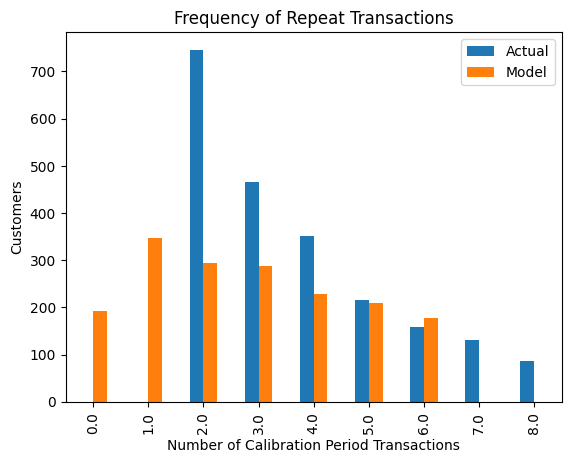

In [ ]:
plot_period_transactions(bgf)

In [ ]:
bgf.conditional_expected_number_of_purchases_up_to_time(1, df_ind['frequency'], df_ind['recency'], df_ind['T']).sort_values(ascending=False).head(10)

,0
Customer ID,
12748.00000,3.21023
17841.00000,1.91594
13089.00000,1.51736
14606.00000,1.44653
15311.00000,1.41714
12971.00000,1.33861
13408.00000,0.97420
18102.00000,0.95700
13798.00000,0.90017


In [ ]:
df_ind['expected_purch_6month'] = bgf.predict(4*6, df_ind['frequency'], df_ind['recency'], df_ind['T'])

In [ ]:
df_ind.sort_values(by='expected_purch_6month', ascending= False).head()

,monetary,recency,T,frequency,expected_purch_6month
Customer ID,,,,,
12748.00000,154.56416,53.14286,53.42857,209,74.07214
17841.00000,328.82234,53.00000,53.42857,124,44.22586
13089.00000,605.18660,52.28571,52.85714,97,35.02411
14606.00000,129.96161,53.14286,53.42857,93,33.40109
15311.00000,667.59681,53.28571,53.42857,91,32.72354


In [ ]:
ggf = GammaGammaFitter(penalizer_coef=0.01)

In [ ]:
ggf.fit(df_ind['frequency'], df_ind['monetary'])

<lifetimes.GammaGammaFitter: fitted with 2570 subjects, p: 3.82, q: 0.35, v: 3.75>

In [ ]:
ggf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,3.81530,0.10216,3.61507,4.01553
q,0.34782,0.00777,0.33259,0.36306
v,3.74935,0.10277,3.54793,3.95077


In [ ]:
ggf.conditional_expected_average_profit(df_ind['frequency'], df_ind['monetary']).sort_values(ascending=False).head(10)

,0
Customer ID,
14088.00000,3911.31997
18102.00000,3595.19278
14096.00000,3191.38743
17511.00000,2938.27484
15749.00000,2675.12249
17450.00000,2639.41955
13081.00000,2616.62528
16984.00000,2452.12985
16000.00000,2181.32644


In [ ]:
#########
df_ind['expected_average_profit'] = ggf.conditional_expected_average_profit(df_ind['frequency'], df_ind['monetary'])
#########

In [ ]:
cltv = ggf.customer_lifetime_value(bgf, df_ind['frequency'], df_ind['recency'], df_ind['T'], df_ind['monetary'], time=6, freq='W')

In [ ]:
cltv = cltv.reset_index()

In [ ]:
cltv_final = df_ind.merge(cltv, on='Customer ID', how='left')

In [ ]:
cltv_final.sort_values(by='clv', ascending=False).head()

,Customer ID,monetary,recency,T,frequency,expected_purch_6month,expected_average_profit,clv
2486,18102.00000,3584.88775,52.28571,52.57143,60,22.10250,3595.19278,83149.29550
589,14096.00000,3159.07706,13.85714,14.57143,17,15.77077,3191.38743,52558.52219
2184,17450.00000,2629.52989,51.28571,52.57143,46,17.01052,2639.41955,46982.46453
2213,17511.00000,2921.95194,52.85714,53.42857,31,11.63438,2938.27484,35775.51209
1804,16684.00000,2120.04696,50.42857,51.28571,28,10.91194,2133.20387,24359.18951


In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [ ]:
cltv_final.head()

,Customer ID,monetary,recency,T,frequency,expected_purch_6month,expected_average_profit,clv
0,12747.00000,381.45545,52.28571,52.85714,11,4.66875,387.82298,1895.35861
1,12748.00000,154.56416,53.14286,53.42857,209,74.07214,154.70864,11990.53698
2,12749.00000,814.48800,29.85714,30.57143,5,3.82617,844.09534,3378.81295
3,12820.00000,235.58500,46.14286,46.71429,4,2.42215,247.08118,626.57058
4,12822.00000,474.44000,2.28571,12.57143,2,2.94800,520.82923,1604.83421


In [ ]:
scaler.fit(cltv_final[['clv']])

MinMaxScaler()

In [ ]:
cltv_final['scaled_cltv'] = scaler.transform(cltv_final[['clv']])

In [ ]:
cltv_final.sort_values(by='scaled_cltv', ascending=False).head()

,Customer ID,monetary,recency,T,frequency,expected_purch_6month,expected_average_profit,clv,scaled_cltv
2486,18102.00000,3584.88775,52.28571,52.57143,60,22.10250,3595.19278,83149.29550,1.00000
589,14096.00000,3159.07706,13.85714,14.57143,17,15.77077,3191.38743,52558.52219,0.63210
2184,17450.00000,2629.52989,51.28571,52.57143,46,17.01052,2639.41955,46982.46453,0.56504
2213,17511.00000,2921.95194,52.85714,53.42857,31,11.63438,2938.27484,35775.51209,0.43026
1804,16684.00000,2120.04696,50.42857,51.28571,28,10.91194,2133.20387,24359.18951,0.29296


In [ ]:
cltv_final.sort_values(by='scaled_cltv', ascending=False).tail()

,Customer ID,monetary,recency,T,frequency,expected_purch_6month,expected_average_profit,clv,scaled_cltv
1437,15881.00000,100.27800,7.42857,52.14286,5,0.01854,104.60401,2.03022,0.00002
2407,17912.00000,62.20200,7.71429,52.14286,5,0.02060,65.18021,1.40557,0.00002
1829,16725.00000,111.57429,9.85714,53.14286,7,0.00658,114.91611,0.79119,0.00001
1079,15107.00000,53.25000,8.71429,53.28571,6,0.01011,55.45477,0.58700,0.00001
2380,17850.00000,156.47000,0.14286,53.42857,34,0.00000,157.37147,0.00000,0.00000


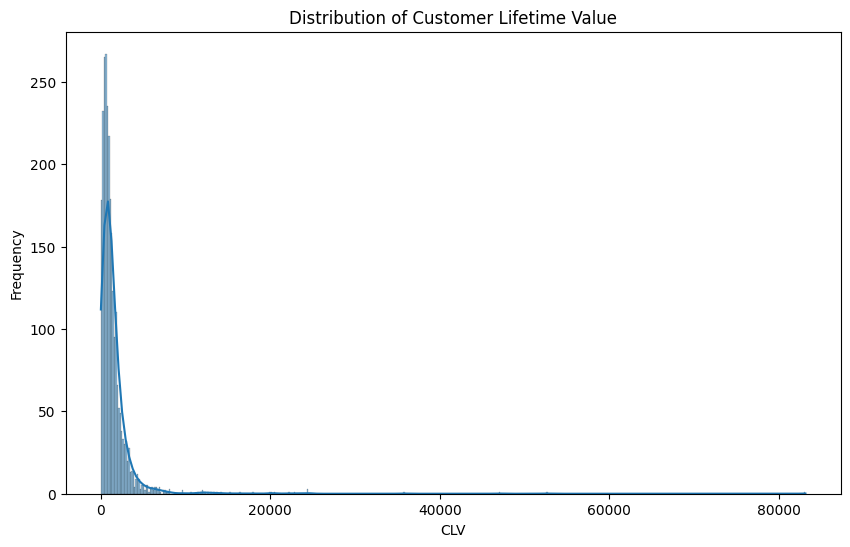

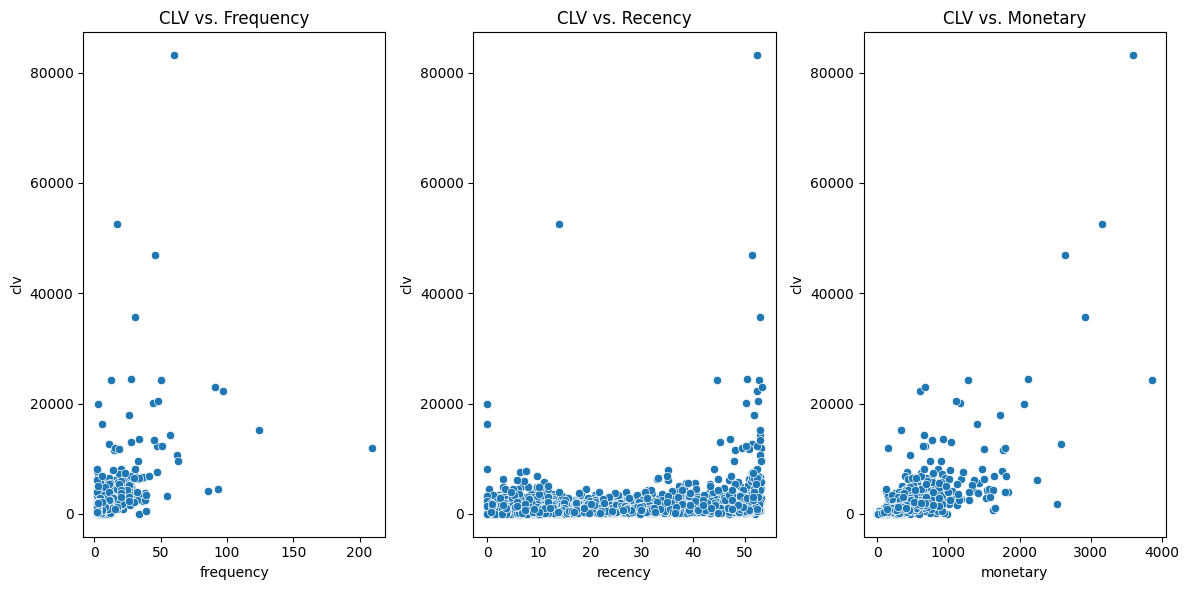

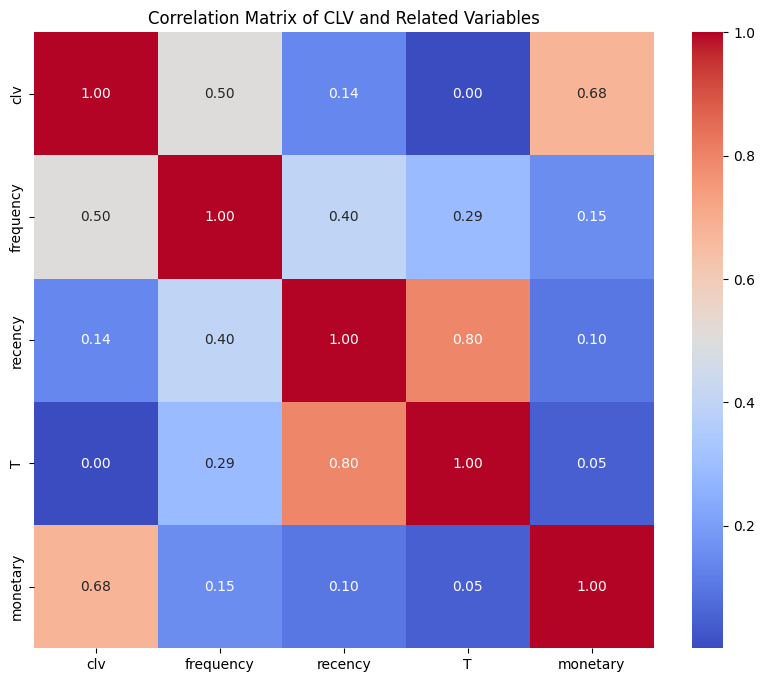

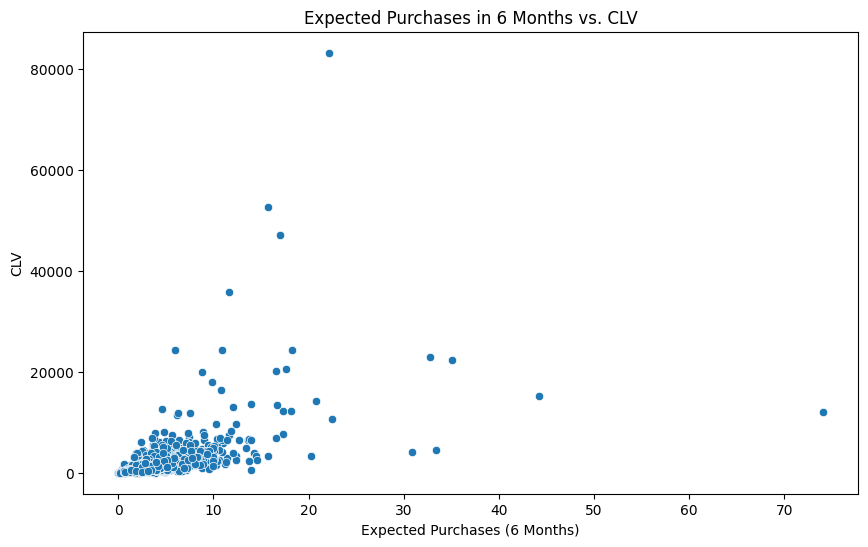

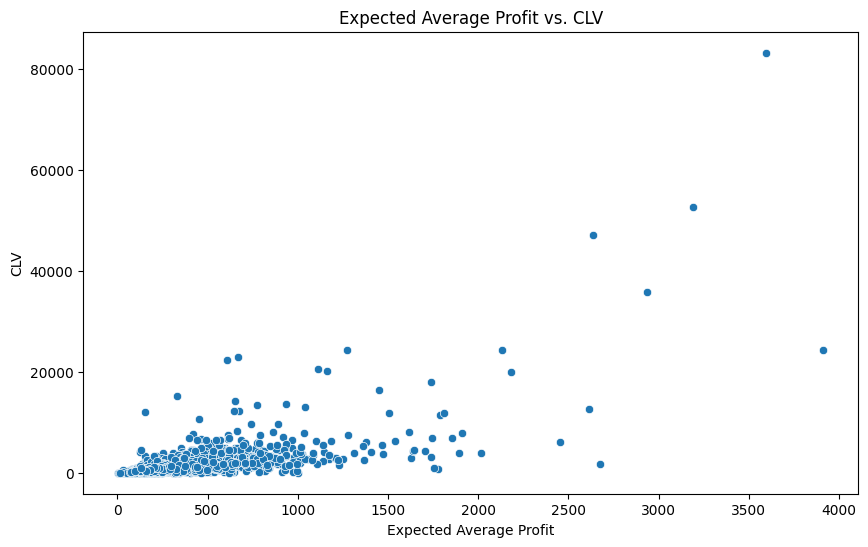

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming cltv_final DataFrame from the previous code is available

# 1. Distribution of CLV
plt.figure(figsize=(10, 6))
sns.histplot(cltv_final['clv'], kde=True)
plt.title('Distribution of Customer Lifetime Value')
plt.xlabel('CLV')
plt.ylabel('Frequency')
plt.show()

# 2. Relationship between CLV and other variables (e.g., frequency, recency, monetary)
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
sns.scatterplot(x='frequency', y='clv', data=cltv_final)
plt.title('CLV vs. Frequency')

plt.subplot(1, 3, 2)
sns.scatterplot(x='recency', y='clv', data=cltv_final)
plt.title('CLV vs. Recency')

plt.subplot(1, 3, 3)
sns.scatterplot(x='monetary', y='clv', data=cltv_final)
plt.title('CLV vs. Monetary')

plt.tight_layout()
plt.show()

# 3. Boxplot of CLV by a categorical variable (if available, e.g., customer segment)
# Example (assuming you have a 'segment' column):
# plt.figure(figsize=(8, 6))
# sns.boxplot(x='segment', y='clv', data=cltv_final)
# plt.title('CLV by Customer Segment')
# plt.show()


# 4. Heatmap of correlations between variables
plt.figure(figsize=(10, 8))
correlation_matrix = cltv_final[['clv', 'frequency', 'recency', 'T', 'monetary']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of CLV and Related Variables')
plt.show()

# 5.  Plot Expected Purchases vs. CLV
plt.figure(figsize=(10,6))
sns.scatterplot(x='expected_purch_6month', y='clv', data=cltv_final)
plt.title('Expected Purchases in 6 Months vs. CLV')
plt.xlabel('Expected Purchases (6 Months)')
plt.ylabel('CLV')
plt.show()

# 6. Plot Expected Average Profit vs. CLV
plt.figure(figsize=(10,6))
sns.scatterplot(x='expected_average_profit', y='clv', data=cltv_final)
plt.title('Expected Average Profit vs. CLV')
plt.xlabel('Expected Average Profit')
plt.ylabel('CLV')
plt.show()